In [1]:
#Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

import seaborn as sns
import matplotlib.patches as mpatches


from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics


In [2]:
#To remove warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#seaborn configuration
sns.set(rc={'figure.figsize':(10,5)}) 
sns.set_style('whitegrid')
sns.set_palette ("Set1")
#sns.set(rc={'figure.figsize':(11.7,8.27)})



## Load data

In [4]:
#file = "data/old/combined_dataframe.csv"
#df = pd.read_csv(file, sep = '\t')  

In [5]:
df_2019 = pd.read_csv("data/2019.csv", sep = '\t')  
df_2020 = pd.read_csv("data/2020.csv", sep = '\t')  
df_2021 = pd.read_csv("data/2021.csv", sep = '\t')  
df_2022 = pd.read_csv("data/2022.csv", sep = '\t') 


In [6]:
df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [7]:
df.to_csv('data/combined_dataframe.csv', index=False, header=True, sep ='\t' )

### Number of races 

In [8]:
print("Number rows dataframe: ")
print(len(df))

Number rows dataframe: 
82523


### Change/add variables

In [9]:
def change_add_var(df):
    # Change the colum HasPitLap, to check if in the next lap it made the lap, and change name to PitNextLap
    
    #Is changing in the current lap, needs to change in the next
    df["NumberPitStops"] = df.groupby(["Year", "RaceNumber", "Driver"])["NumberPitStops"].shift(1).fillna(0)

    #Data from previus lap
    df["TimeLap"] = df.groupby(["Year", "RaceNumber", "Driver"])["TimeLap"].shift(1).fillna(0)

    return df

In [10]:
df = change_add_var(df)

### Remove variables 

In [11]:
# the data was compiled, but then was not useful 
def remonve_var(df):
    df = df.drop(['DriverNumber'], axis=1)
    df = df.drop(['DriverAhead'], axis=1)
    df = df.drop(['DriverBehind'], axis=1)
    df = df.drop(['TimePit'], axis=1)
    return df

In [12]:
df = remonve_var(df)

## Pit stops info 

In [13]:
df["HasPitLap"].value_counts()/df.shape[0]


0.0    0.967888
1.0    0.031870
Name: HasPitLap, dtype: float64

In [14]:
df["GoodPitStop"].value_counts()/df.shape[0]


0    0.983386
1    0.016614
Name: GoodPitStop, dtype: float64

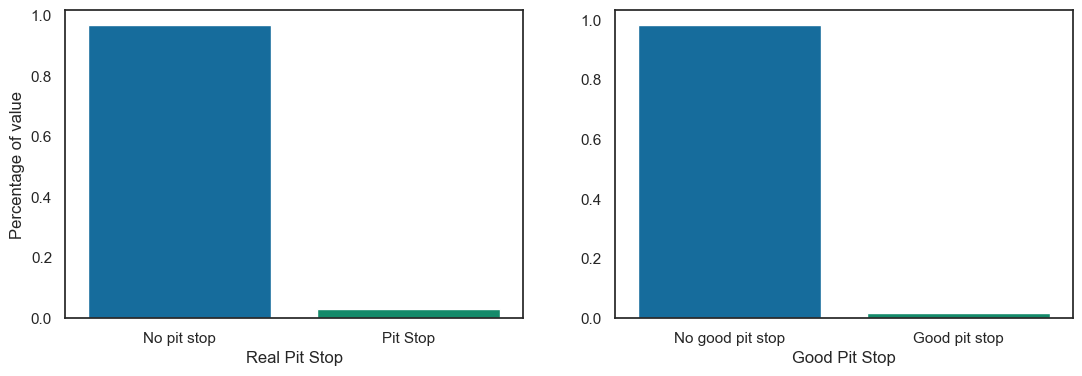

In [15]:
# Create figure with two subplots
#palette = {0: 'blue', 1: 'green'}
my_palette = ["#0072B2", "#009E73"]
sns.set_style('white')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 4))

# Plot first bar plot for GoodPitStop variable
value_counts1 = df["HasPitLap"].value_counts()/df.shape[0]
sns.barplot(x=value_counts1.index, y=value_counts1.values, ax=ax1, palette=my_palette)
ax1.set_ylabel('Percentage of value')
ax1.set_xlabel('Real Pit Stop')

# Plot second bar plot for HasPitLap variable
value_counts2 = df["GoodPitStop"].value_counts()/df.shape[0]
sns.barplot(x=value_counts2.index, y=value_counts2.values, ax=ax2, palette=my_palette)
ax2.set_ylabel('')
ax2.set_xlabel('Good Pit Stop')

ax1.set_xticklabels(['No pit stop', 'Pit Stop'])
ax2.set_xticklabels(['No good pit stop', 'Good pit stop'])

plt.show()


# Data cleaning

### Pit stops por faster lap

In [16]:
def remove_FastestLap(df):
    number_fl = 0
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if (val.iloc[-3:]['HasPitLap'] == 1).any():
                    df = df.drop(val.index)
                    number_fl +=1 
    
    print (number_fl)
    return df

In [17]:
df = remove_FastestLap (df)

55


## Rainy races
Races with rain, i.e. those in which intermediate or wet tires are used, are eliminated. 

### Plot

In [18]:
#For the spa race in 2021 we have some 'UNKNOWN' values, remove them 
df = df[df['Compound'] != 'UNKNOWN']


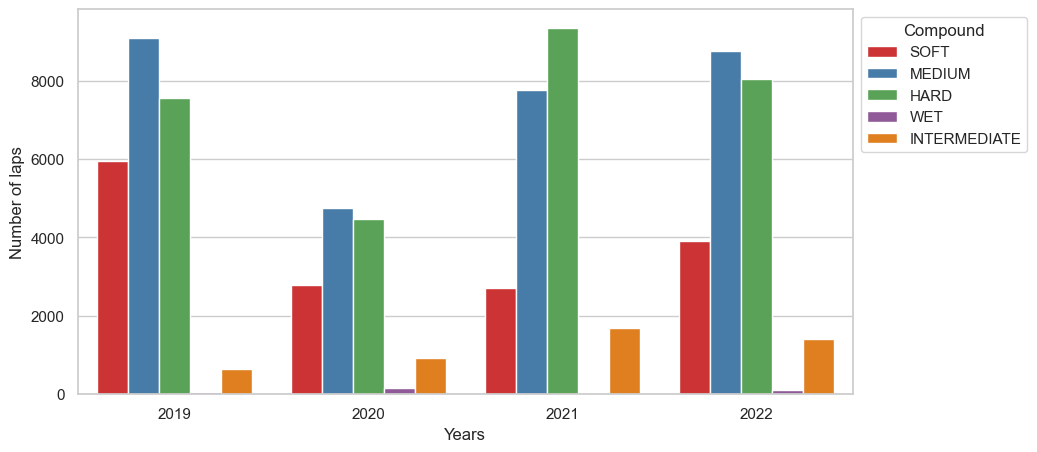

In [19]:
sns.set_style('whitegrid')

value_counts = df.groupby('Year')['Compound'].value_counts()
all_values = pd.MultiIndex.from_product([df['Year'].unique(), df['Compound'].unique()])
value_counts = value_counts.reindex(all_values, fill_value=0)

value_counts = value_counts.reset_index()
value_counts.columns = ['Year', 'Compound', "Value"]

# Set y-label to "number of laps"
plot = sns.barplot(x='Year', y='Value', hue='Compound', data=value_counts)
plot.set_ylabel('Number of laps')
plot.set_xlabel('Years')
plt.legend(title='Compound', bbox_to_anchor=(1, 1))

### Deleted 

In [20]:
def remove_rain(df):
    #Initialized in 1, because I have removed by hand spa in 2021 already gave an error 
    initial_races = 0
    rain_races= 0 
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            initial_races+=1
            val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]
            #If in that race any driver uses Intermediate or wet tyres, delete the all the sace
            if ('INTERMEDIATE' in val['Compound'].values or 'WET' in val['Compound'].values):
                rain_races +=1
                df = df.drop(val.index)

    print("Total races in the DataSet: " + str(initial_races))
    print("Number of races that have been eliminated due to rain: " + str(rain_races))

    return (df)


In [21]:
df = remove_rain(df)

Total races in the DataSet: 77
Number of races that have been eliminated due to rain: 12


## Remove laps per time

In [22]:
v_date= ['TimeLap', 'TimeDiffAhead', 'TimeDiffBehind', 'TimeDiffToLeader'] # 'TimePit'
#TODO

def remove_time (df):
    #Convert the times to secods 
    df['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
    df['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
    df['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
    df['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()


    df = df.drop(df[df['TimeLap']> 240].index)
    df = df.drop(df[df['TimeDiffToLeader']> 210].index)
    df = df.drop(df[df['TimeDiffAhead']> 60].index)
    df = df.drop(df[df['TimeDiffBehind']> 60].index)
    return df

In [23]:
#df = remove_time(df)
#TODO

## Retired or more than 4 stops 

In [24]:
def remove_retired(df):
    list_remove = pd.DataFrame()
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ('Finished' != val["ResultStatus"].iloc[0] and '+1 Lap' != val["ResultStatus"].iloc[0] and '+2 Laps' != val["ResultStatus"].iloc[0]):
                    list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': val["ResultStatus"].iloc[0]}, ignore_index=True)
                    df = df.drop(val.index) 
                    #TODO
                elif val["NumberPitStops"].iloc[-1] >4:  
                    list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': "+4 pit stops"}, ignore_index=True)
                    df = df.drop(val.index)
    
    return df, list_remove

In [25]:
df, list_remove = remove_retired(df)


### Plot

Text(0.5, 0, 'Reason for deleted')

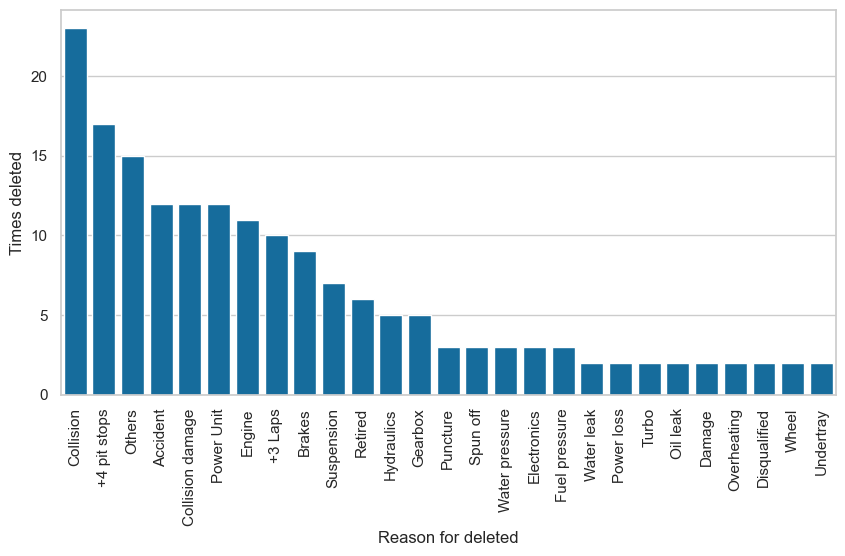

In [26]:
sns.set_style('whitegrid')
my_palette = ["#0072B2"]

value_counts = list_remove["problem"].value_counts()

#plot
fig, ax = plt.subplots(figsize=(10, 5))


# Find values that occur only once
single_counts = value_counts[value_counts == 1].index
# Replace single-count values with 'others'
list_remove["problem"] = list_remove["problem"].replace(single_counts, "Others")
# Count the occurrences of each value in the modified Series
value_counts = list_remove["problem"].value_counts()

ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=my_palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Times deleted')
ax.set_xlabel('Reason for deleted')

## Null values

In [27]:
null_cols = df.columns[df.isnull().any()]
print(null_cols)

Index(['QualyPosition', 'DriverStandings'], dtype='object')


In [28]:
def remove_null (df): 
    #Qualy Position and GridPosition
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ( np.isnan(val["QualyPosition"].iloc[0])):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "QualyPosition"] = val["Position"].iloc[0]
                if ( val["GridPosition"].iloc[0] == 0):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "GridPosition"] = val["Position"].iloc[0]
    
    #DriverStandings
    df['DriverStandings'] = df['DriverStandings'].fillna(0)

    return df

In [29]:
df = remove_null (df)

### Export df

In [30]:
df.to_csv('data/combined_dataframe_clean.csv', index=False, header=True, sep ='\t' )

## Final number laps

In [31]:
print("Number rows dataframe after preprocesing: ")
print(len(df))

Number rows dataframe after preprocesing: 
62566


In [32]:
df = df.reset_index(drop=True)  # Reset the index labels

# Data Visualization

In [33]:
v_categorical= ['Year', 'RaceName', 'Driver', 'Team', 'Compound', 'TrackStatus'] #'TrackStatus' is categorical, but make in a different way 

v_numerical = ['RaceNumber', 'GridPosition', 'LapNumber', 'TyreLife', 
               'QualyPosition', 'DriverStandings', 'Position',
               'NumberPitStops']
v_binary = ['TyresChange','DriverAheadPit', 'DriverBehindPit' ]
v_date= ['TimeLap', 'TimeDiffAhead', 'TimeDiffBehind', 'TimeDiffToLeader'] 

### Categorical

In [34]:
#Create DF for track status
trackStatus_encoded = pd.DataFrame()
df['TrackStatus'] = df['TrackStatus'].astype(str)
for num in range(1, 8):
    col_name = 'Status ' + str(num)
    trackStatus_encoded[col_name] = df['TrackStatus'].str.contains(str(num)).astype(int)
    
# create a new DataFrame with the count of each column
count_trackStatus = trackStatus_encoded.sum().reset_index()
count_trackStatus.columns = ['column_name', 'count']


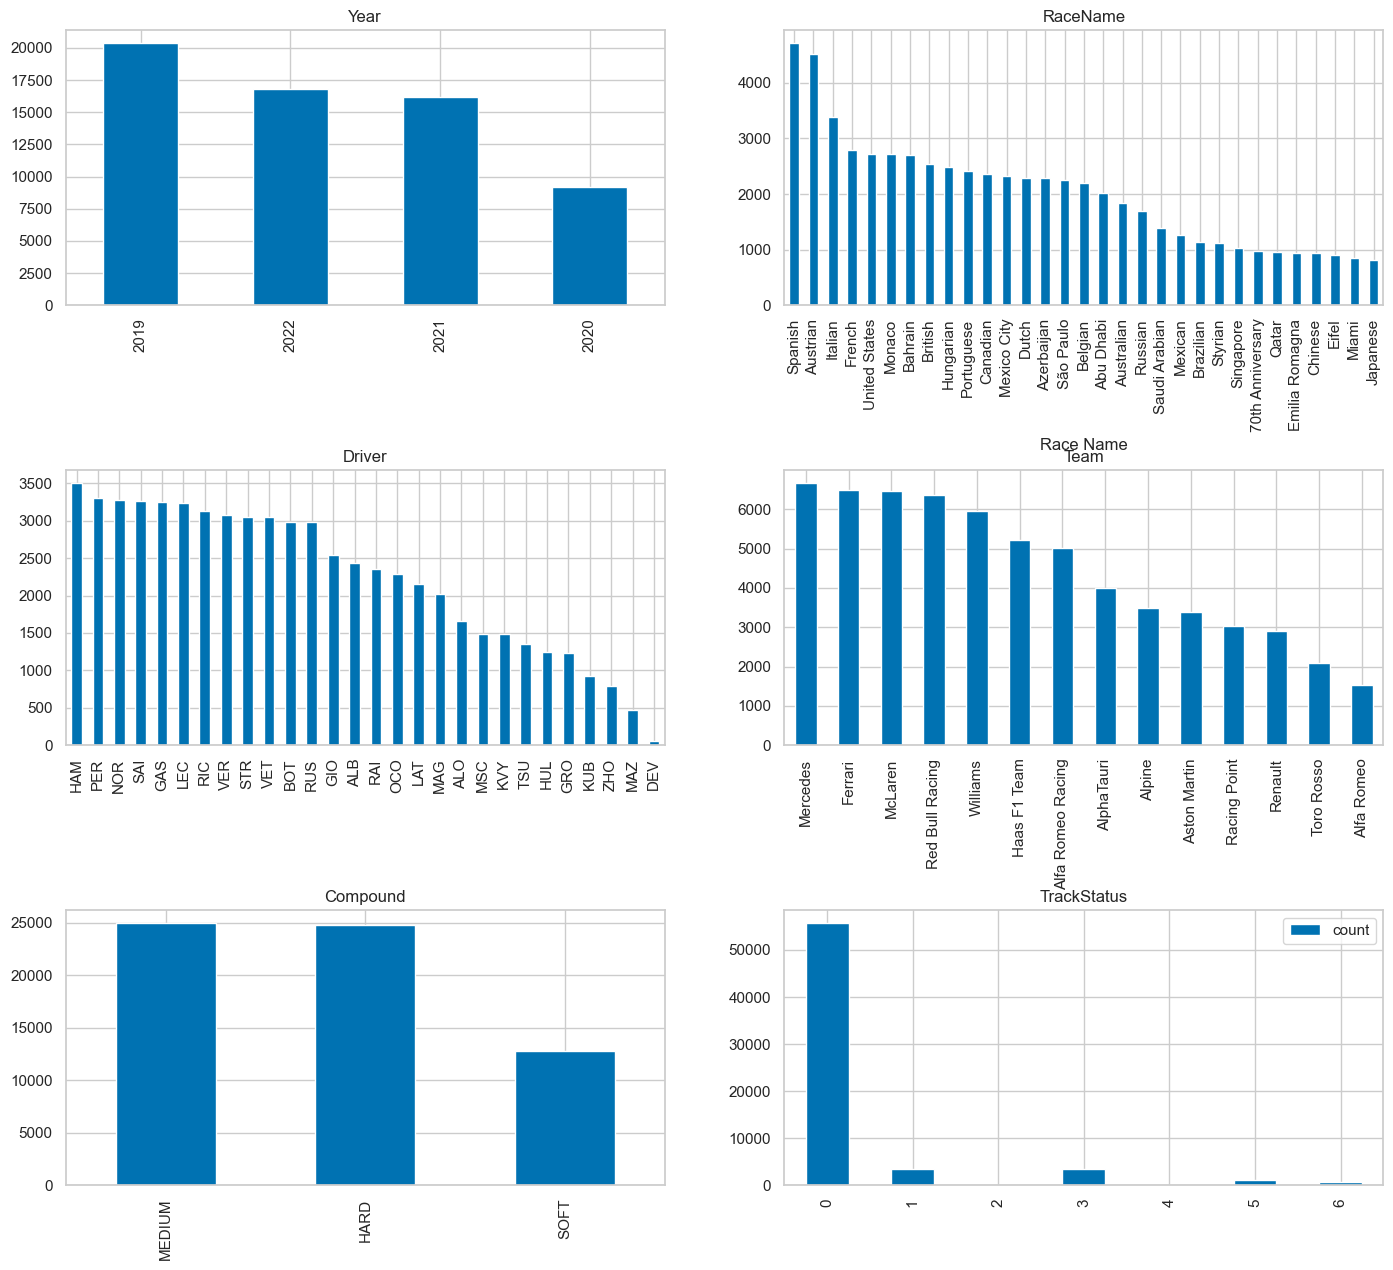

In [35]:
# create a new figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(17, 15))

# loop through each categorical variable and plot a bar chart
for col_idx, col in enumerate(v_categorical):
    row_idx, col_idx = np.unravel_index(col_idx, (3,2))
    
    if col == 'RaceName':
        race_names = df[col].str.replace(' Grand Prix', '')
        race_names.value_counts().plot.bar(ax=axes[row_idx,col_idx], color='#0072B2')
        axes[row_idx,col_idx].set_title(col)
        axes[row_idx,col_idx].set_xlabel('Race Name')

    elif col == 'TrackStatus':
        count_trackStatus.plot.bar(ax=axes[row_idx,col_idx], color='#0072B2')
        axes[row_idx,col_idx].set_title(col)
        
    else:
        df[col].value_counts().plot.bar(ax=axes[row_idx,col_idx], color='#0072B2')
        axes[row_idx,col_idx].set_title(col)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2, hspace=0.6)

# display the plot
plt.show()


### Binary

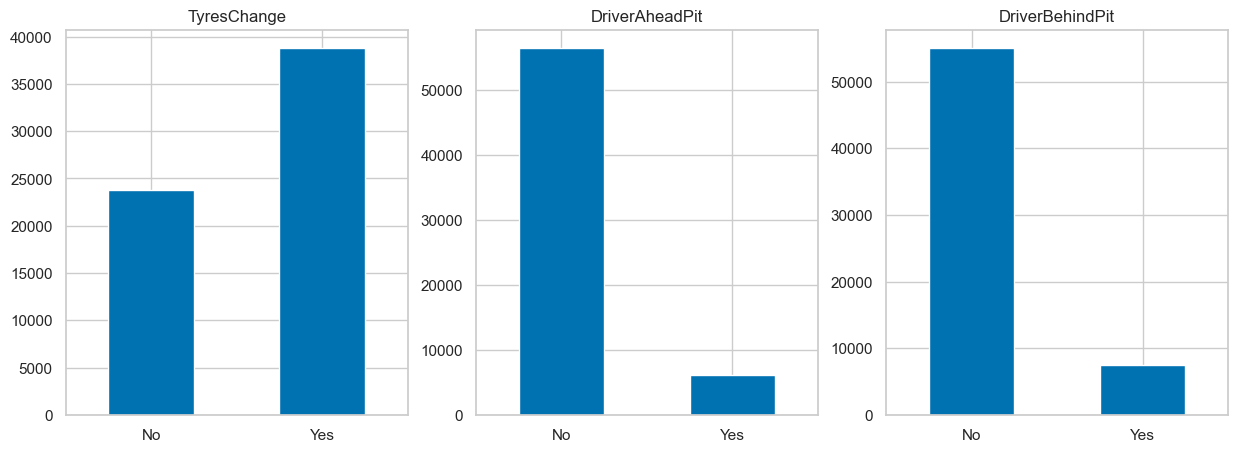

In [36]:
df[v_binary] = df[v_binary].astype(int)
df[v_binary].replace({0: 'No', 1: 'Yes'}).apply(pd.value_counts).plot.bar(subplots=True, layout=(1, 3), figsize=(15,5), color="#0072B2", rot=0, legend=False)
plt.show()


### Numerical

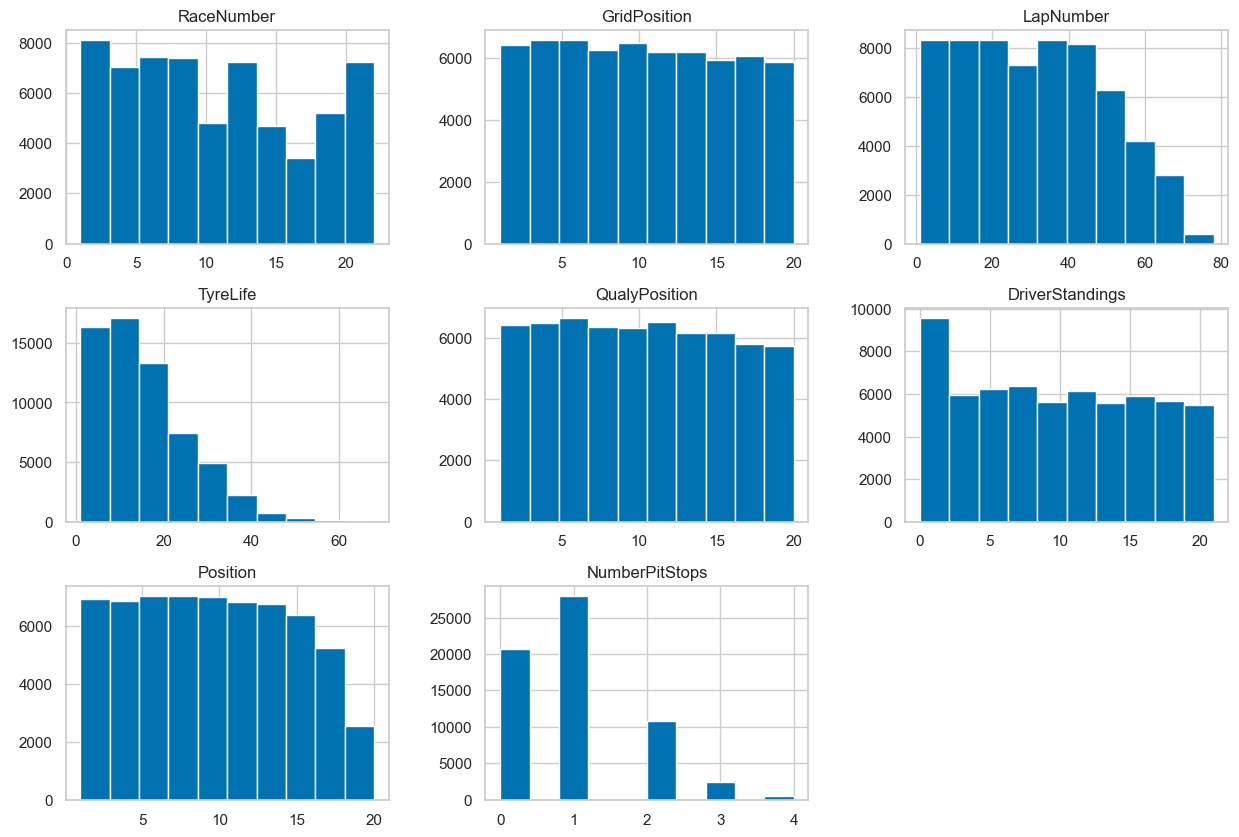

In [37]:
df[v_numerical].hist(layout=(3, 3), figsize=(15,10), color="#0072B2")
plt.show()

### Date

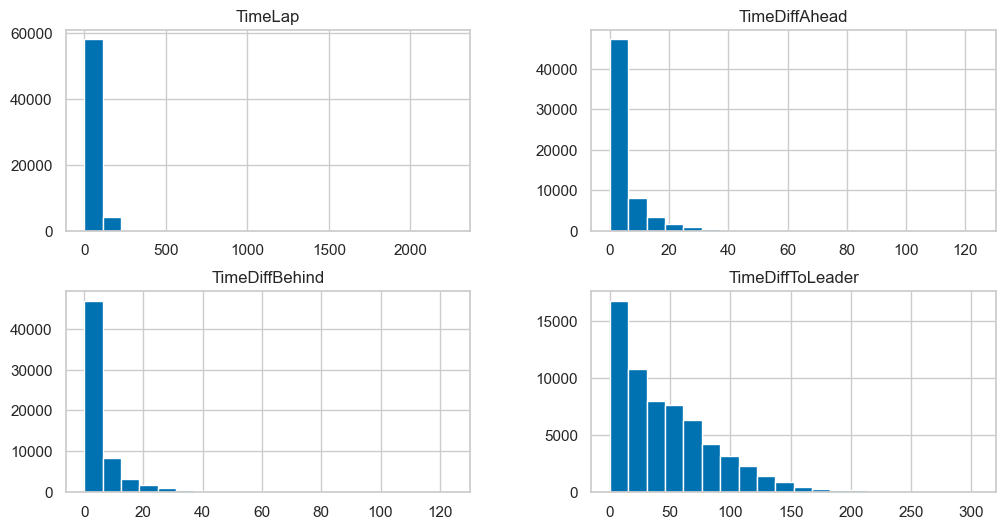

In [38]:
df_time = pd.DataFrame()
df_time['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
df_time['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
df_time['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
df_time['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()

df_time.hist(figsize=(12,6), color="#0072B2", bins=20)
plt.show()

# Data Preprocessing

### Categorical 

In [39]:
def categorical_enc (df):
    v_cat= ['Year', 'RaceName', 'Driver', 'Team', 'Compound']  #TODO

    #Track status
    trackStatus_encoded =  pd.DataFrame()
    df['TrackStatus'] = df['TrackStatus'].astype(str)
    for num in range(1, 8):
        col_name = 'status_' + str(num)
        trackStatus_encoded[col_name] = df['TrackStatus'].str.contains(str(num)).astype(int)
    
    #the rest
    ohe = OneHotEncoder(sparse=False)
    categorical_encoded = pd.DataFrame(ohe.fit_transform(df[v_cat]))
    # Get feature names from encoder and combine with unique values
    feature_names = [f"{col}_{val}" for col, vals in zip(v_cat, v_cat) for val in ohe.categories_[v_cat.index(col)]]
    categorical_encoded.columns = feature_names

    #Combine with track status 
    categorical_encoded = pd.concat([categorical_encoded, trackStatus_encoded], axis=1)
   
    return categorical_encoded

### Binary

In [40]:
def binary_enc (df):
    #It's already encoded, juto convert all to int 
    binary_encoded = df[v_binary].astype(int)
    return binary_encoded

### Numerical

In [41]:
def numerical_enc (df):
    #StandarScaler
    scaler = StandardScaler()
    numerical_encoded = df.groupby(['Year', 'RaceNumber'])[v_numerical].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

    return numerical_encoded

### Date

In [42]:
def date_enc(df):
    #Convert the times to secods 
    df['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
    df['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
    df['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
    df['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()

    scaler = StandardScaler()
    date_encoded = df.groupby(['Year', 'RaceNumber'])[v_date].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

    return date_encoded

## Enconde

In [43]:
def encode_df (df): 
    categorical_encoded = categorical_enc(df)
    binary_encoded = binary_enc(df)
    numerical_encoded = numerical_enc(df)
    date_encoded = date_enc(df)

    df_encoded = pd.concat([categorical_encoded, binary_encoded, numerical_encoded, date_encoded], axis=1)
    return df_encoded

In [44]:
df_encoded = encode_df (df)
df_encoded

,Year_2019,Year_2020,Year_2021,Year_2022,RaceName_70th Anniversary Grand Prix,RaceName_Abu Dhabi Grand Prix,RaceName_Australian Grand Prix,RaceName_Austrian Grand Prix,RaceName_Azerbaijan Grand Prix,RaceName_Bahrain Grand Prix,...,LapNumber,TyreLife,QualyPosition,DriverStandings,Position,NumberPitStops,TimeLap,TimeDiffAhead,TimeDiffBehind,TimeDiffToLeader
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.701740,-1.211369,-1.377895,0.000000,-1.584317,-1.297384,-7.226051,-0.680778,-0.544589,-1.288219
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.641308,-1.119913,-1.377895,0.000000,-1.584317,-1.297384,0.433598,-0.680778,-0.539114,-1.288219
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.580875,-1.028457,-1.377895,0.000000,-1.584317,-1.297384,0.094677,-0.680778,-0.534259,-1.288219
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.520442,-0.937001,-1.377895,0.000000,-1.584317,-1.297384,0.060711,-0.680778,-0.525058,-1.288219
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.460009,-0.845545,-1.377895,0.000000,-1.584317,-1.297384,0.011314,-0.680778,-0.516308,-1.288219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62561,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.422559,1.393083,1.027476,0.473854,1.469650,0.158780,0.148638,2.296950,4.485850,2.794199
62562,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.482647,1.509222,1.027476,0.473854,1.469650,0.158780,0.173930,2.100669,5.030943,2.911249
62563,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.542735,1.625362,1.027476,0.473854,1.469650,0.158780,0.204790,2.095820,9.828378,3.001758
62564,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.602824,1.741502,1.027476,0.473854,1.286434,0.158780,0.164386,1.638832,-0.795083,3.095589


In [46]:
df_encoded.to_csv("data/encoded_data.csv")

# Classification

### Split dataframe
* Train -> 2019 2020
* Validation  -> 2021
* Test -> 2022

In [682]:
def conf_matrix_classifier_from_predictions(classifier, X, y, name = ""):
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X,
        y,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title('Confusion Matrix: ' + name)
    plt.show()

In [683]:
#! TODO
""" 


from sklearn.model_selection import train_test_split 
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitNextLap'], test_size=0.3, random_state=4815)
X_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['PitNextLap'], test_size=0.3, random_state=4815)

#TODO Add validation and and 2023
train_years= [2019, 2020, 2021]
test_years = [2022]

y_train_years_GP = df[df['Year'].isin(train_years)]['GoodPitLap']
y_test_years_GP= df[df['Year'].isin(test_years)]['GoodPittLap']
X_train_years_GP = df_encoded.loc[y_train_years_GP.index]
X_test_years_GP = df_encoded.loc[y_test_years_GP.index]

y_train_years_HP = df[df['Year'].isin(train_years)]['PitNextLap']
y_test_years_HP= df[df['Year'].isin(test_years)]['PitNextLap']
X_train_years_HP = df_encoded.loc[y_train_years_HP.index]
X_test_years_HP = df_encoded.loc[y_test_years_HP.index]

"""

" \n\n\nfrom sklearn.model_selection import train_test_split \nX_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitNextLap'], test_size=0.3, random_state=4815)\nX_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['PitNextLap'], test_size=0.3, random_state=4815)\n\n#TODO Add validation and and 2023\ntrain_years= [2019, 2020, 2021]\ntest_years = [2022]\n\ny_train_years_GP = df[df['Year'].isin(train_years)]['GoodPitLap']\ny_test_years_GP= df[df['Year'].isin(test_years)]['GoodPittLap']\nX_train_years_GP = df_encoded.loc[y_train_years_GP.index]\nX_test_years_GP = df_encoded.loc[y_test_years_GP.index]\n\ny_train_years_HP = df[df['Year'].isin(train_years)]['PitNextLap']\ny_test_years_HP= df[df['Year'].isin(test_years)]['PitNextLap']\nX_train_years_HP = df_encoded.loc[y_train_years_HP.index]\nX_test_years_HP = df_encoded.loc[y_test_years_HP.index]\n\n"

In [684]:


#TODO Add validation and and 2023
train_years= [2019, 2020, 2021]
test_years = [2022]

y_train_years_GP = df[df['Year'].isin(train_years)]['GoodPitStop']
y_test_years_GP= df[df['Year'].isin(test_years)]['GoodPitStop']
X_train_years_GP = df_encoded.loc[y_train_years_GP.index]
X_test_years_GP = df_encoded.loc[y_test_years_GP.index]

y_train_years_HP = df[df['Year'].isin(train_years)]['HasPitLap']
y_test_years_HP= df[df['Year'].isin(test_years)]['HasPitLap']
X_train_years_HP = df_encoded.loc[y_train_years_HP.index]
X_test_years_HP = df_encoded.loc[y_test_years_HP.index]


from sklearn.model_selection import train_test_split 
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(df_encoded, df['GoodPitStop'], test_size=0.3, random_state=4815)
X_train_HP, X_test_HP, y_train_HP, y_test_HP = train_test_split(df_encoded, df['HasPitLap'], test_size=0.3, random_state=4815)


In [685]:
# Aply PCA

from sklearn.decomposition import PCA


# Create a PCA object with the specified variance threshold
pca = PCA(n_components=0.95)

# Fit the PCA on the training data and transform both the training and test data
X_train_pca = pca.fit_transform(X_train_HP)
X_test_pca = pca.transform(X_test_HP)

# Print the number of features after PCA
print(f"Number of features after PCA: {X_train_pca.shape[1]}")

Number of features after PCA: 49


In [686]:
from sklearn.svm import SVC
from sklearn import metrics

SVM_res = SVC(class_weight="balanced", C=10, gamma= 0.3, kernel= 'poly')
SVM_res.fit(X_train_HP, y_train_HP)
Y_pred = SVM_res.predict(X_test_HP)


print(metrics.confusion_matrix(y_test_HP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_HP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_HP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_HP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_HP,Y_pred),3)))

[[19740   175]
 [  268   292]]
Accuracy : 0.978
Precision : 0.625
Recall : 0.521
F1 : 0.569


In [690]:
from sklearn.svm import SVC
from sklearn import metrics

SVM_res = SVC(class_weight="balanced", C=0.15, gamma= 0.8, kernel= 'poly')
SVM_res.fit(X_train_pca, y_train_HP)
Y_pred = SVM_res.predict(X_test_pca)


print(metrics.confusion_matrix(y_test_HP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_HP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_HP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_HP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_HP,Y_pred),3)))

[[19614   301]
 [  280   280]]
Accuracy : 0.972
Precision : 0.482
Recall : 0.5
F1 : 0.491


In [687]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# Define the hyperparameter distribution to search over
param_dist = {
    'C': reciprocal(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + list(uniform(0.01, 1).rvs(10))
}

# Initialize the SVM model with balanced class weights
SVM_res = SVC(class_weight="balanced")

# Define the randomized search object
rand_search = RandomizedSearchCV(
    SVM_res, param_distributions=param_dist, scoring='f1', n_jobs=-1, cv=5,
    n_iter=50, random_state=42
)

# Fit the randomized search on the training data
rand_search.fit(X_train_GP, y_train_GP)

# Print the best parameters found by the randomized search
print(f"Best parameters: {rand_search.best_params_}")

# Get the best model from the randomized search and use it to make predictions on the test data
best_SVM_res = rand_search.best_estimator_
Y_pred = best_SVM_res.predict(X_test_GP)

# Print the classification report
print(metrics.classification_report(y_test_GP, Y_pred))


Best parameters: {'C': 0.15517445651473882, 'gamma': 0.8153291311065655, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20201
           1       0.47      0.40      0.43       274

    accuracy                           0.99     20475
   macro avg       0.73      0.70      0.71     20475
weighted avg       0.98      0.99      0.99     20475



### Random forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight="balanced")
print("F1 score values Random Forest:")
#Pit stop 

#Random split
rf.fit(X_train_HP, y_train_HP)
y_pred = rf.predict(X_test_HP)
print( "train_test_split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_HP,y_pred),3)))

""" 

#Year split
rf.fit(X_train_years_HP, y_train_years_HP)
y_pred = rf.predict(X_test_years_HP)
print( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))


#Good pit stop 
#Random split
rf.fit(X_train_HP, y_train_GP)
y_pred = rf.predict(X_test_GP)
print( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))
#Year split
rf.fit(X_train_years_GP, y_train_years_GP)
y_pred = rf.predict(X_test_years_GP)
print( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3)))
"""


F1 score values Random Forest:
train_test_split for HasPitLap : 0.22


' \n\n#Year split\nrf.fit(X_train_years_HP, y_train_years_HP)\ny_pred = rf.predict(X_test_years_HP)\nprint( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))\n\n\n#Good pit stop \n#Random split\nrf.fit(X_train_HP, y_train_GP)\ny_pred = rf.predict(X_test_GP)\nprint( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))\n#Year split\nrf.fit(X_train_years_GP, y_train_years_GP)\ny_pred = rf.predict(X_test_years_GP)\nprint( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3)))\n'

### SVM

In [433]:
from sklearn.svm import SVC
from sklearn import metrics

SVM_res = SVC()

SVM_res = SVC(class_weight="balanced")
print("F1 score values SMV:")
#Pit stop 

#Random split
SVM_res.fit(X_train_HP, y_train_HP)
y_pred = SVM_res.predict(X_test_HP)
print( "train_test_split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_HP,y_pred),3)))

""" 
#Year split
SVM_res.fit(X_train_years_HP, y_train_years_HP)
y_pred = SVM_res.predict(X_test_years_HP)
print( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))


#Good pit stop 
#Random split
SVM_res.fit(X_train_HP, y_train_GP)
y_pred = SVM_res.predict(X_test_GP)
print( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))
#Year split
SVM_res.fit(X_train_years_GP, y_train_years_GP)
y_pred = SVM_res.predict(X_test_years_GP)
print( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3))
"""


F1 score values SMV:
train_test_split for HasPitLap : 0.407


' \n#Year split\nSVM_res.fit(X_train_years_HP, y_train_years_HP)\ny_pred = SVM_res.predict(X_test_years_HP)\nprint( "Year split for HasPitLap : " + str(np.round(metrics.f1_score(y_test_years_HP,y_pred),3)))\n\n\n#Good pit stop \n#Random split\nSVM_res.fit(X_train_HP, y_train_GP)\ny_pred = SVM_res.predict(X_test_GP)\nprint( "train_test_split for GoodPit : " + str(np.round(metrics.f1_score(y_test_GP,y_pred),3)))\n#Year split\nSVM_res.fit(X_train_years_GP, y_train_years_GP)\ny_pred = SVM_res.predict(X_test_years_GP)\nprint( "Year split for GoodPit : " + str(np.round(metrics.f1_score(y_test_years_GP,y_pred),3))\n'

### Graph 2023

In [434]:
df_2023 = pd.read_csv("data/2023.csv", sep = '\t') 


In [435]:

df_2023 = pd.read_csv("data/2023.csv", sep = '\t') 

#Clean data

df_2023 = change_add_var(df_2023)
df_2023 = remonve_var(df_2023)
#df_2023 = remove_FastestLap(df_2023)
df_2023 = remove_rain(df_2023)
df_2023 = remove_time(df_2023)
df_2023, list_remove = remove_retired(df_2023)
df_2023 = remove_null (df_2023)

#Encode
df_encoded_2023 =  encode_df(df_2023)

Total races in the DataSet: 3
Number of races that have been eliminated due to rain: 0


In [311]:
y_train_full = df['HasPitLap']
X_train_full = df_encoded.loc[y_train_full.index]


In [436]:
#This is the best results 

#TODO train with the best
#from sklearn.svm import SVC
SVM_res = SVC(class_weight="balanced")

#SVM_res.fit( X_train_full, y_train_full)
SVM_res.fit(X_train_HP, y_train_HP)


In [1]:
#Chose the one that i want to print
receN = 1

In [2]:
df_list = []
for driver in df_2023['Driver'].unique() :

    race_driver = df_2023[(df_2023['Driver'] == driver)  & (df_2023['RaceNumber'] == receN)]
    if(len(race_driver) == 0) : #its one of the deleted drivers
        continue
    
    to_predict = df_encoded_2023.loc[race_driver.index].reindex(columns=X_train_full.columns, fill_value=0)
    
    null_cols = to_predict.columns[to_predict.isnull().any()]

    predictions = SVM_res.predict(to_predict).astype(int)
    real = race_driver['HasPitLap'].values
    #real = race_driver['PitNextLap'].values


    laps = np.arange(1, len(real)+1)

    driver_df = pd.DataFrame({'Driver': [driver]*len(real),
                              'Real': real,
                              'Predict': predictions,
                              'Lap': laps})

    df_list.append(driver_df)

plot_df = pd.concat(df_list, ignore_index=True)

# Create a colum for the color 
# 0: No pit, not predicted 
# 1: No pit, yes predicted 
# 2: Yes pit, not predicted 
# 3: Yes pit, yes predicted 
plot_df['ColorCode'] = (plot_df['Real'] * 2 + plot_df['Predict']).astype(int)


NameError: name 'df_2023' is not defined

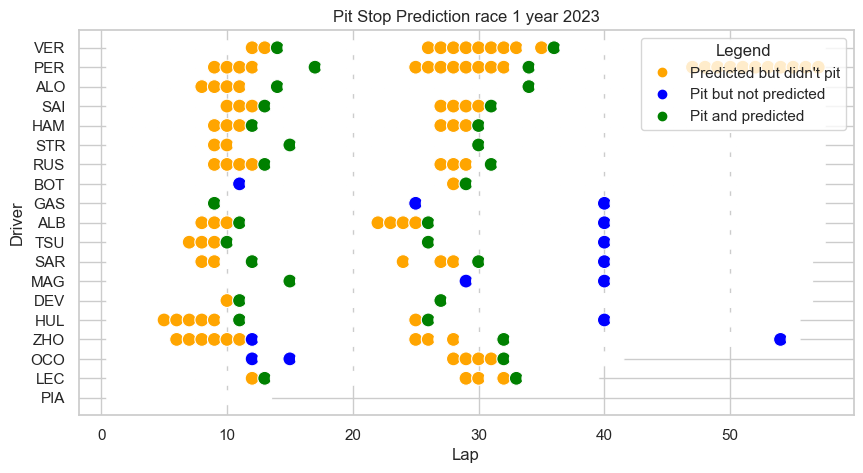

In [316]:
import seaborn as sns

# Define color palette and labels
palette = {0: 'white', 1: 'orange', 2: 'blue', 3: 'green'}
labels = { 1: 'Predicted but didn\'t pit', 2: 'Pit but not predicted', 3: 'Pit and predicted'}
label_colors = { 1: 'orange', 2: 'blue', 3: 'green'}

# Create scatter plot
sns.scatterplot(data=plot_df, x='Lap', y='Driver', hue='ColorCode', palette=palette, s=100)

# Add title and legend
plt.title('Pit Stop Prediction race 1 year 2023')
#plt.legend(title='Legend', labels=labels.values(),  loc='upper right')
plt.legend(title='Legend', labels=labels.values(),  loc='upper right', 
           handles=[plt.Line2D([], [], marker='o', color=label_colors[i], linestyle='') for i in labels.keys()])

plt.show()

### Random forest

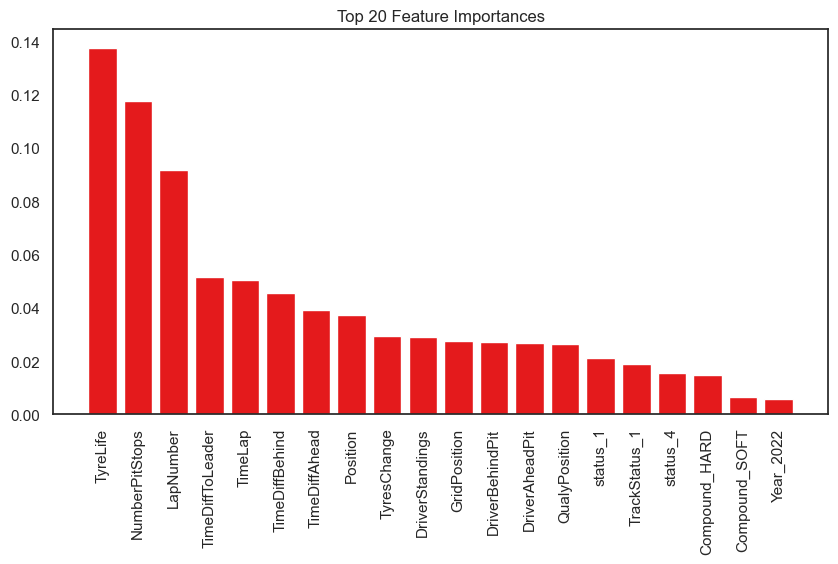

In [54]:
import matplotlib.pyplot as plt

# Train random forest classifier
rf = RandomForestClassifier(class_weight="balanced")
rf.fit(X_train_HP, y_train_HP)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]


# Set number of features to plot
num_features = 20

# Plot feature importances for the top num_features
plt.figure()
plt.title(f"Top {num_features} Feature Importances")
plt.bar(range(num_features), importances[indices][:num_features])
plt.xticks(range(num_features), X_train_HP.columns[indices][:num_features], rotation=90)
plt.show()

### SVM

In [56]:
# Aply PCA

from sklearn.decomposition import PCA


# Create a PCA object with the specified variance threshold
pca = PCA(n_components=0.90)

# Fit the PCA on the training data and transform both the training and test data
X_train_pca = pca.fit_transform(X_train_HP)
X_test_pca = pca.transform(X_test_HP)

# Print the number of features after PCA
print(f"Number of features after PCA: {X_train_pca.shape[1]}")

Number of features after PCA: 31


In [59]:
from sklearn.svm import SVC
from sklearn import metrics

SVM_res = SVC(class_weight="balanced", C=10, gamma= 1, kernel= 'poly')
SVM_res.fit(X_train_pca, y_train_HP)
Y_pred = SVM_res.predict(X_test_pca)


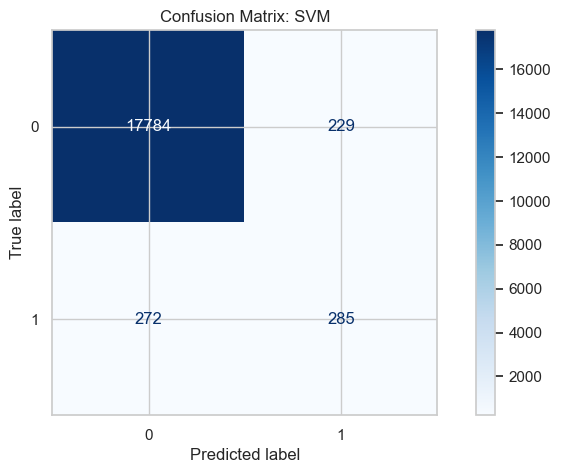

[[17784   229]
 [  272   285]]
Accuracy : 0.973
Precision : 0.554
Recall : 0.512
F1 : 0.532


In [60]:
conf_matrix_classifier_from_predictions(SVM_res, X_test_pca, y_test_HP, name = 'SVM')


print(metrics.confusion_matrix(y_test_HP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_HP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_HP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_HP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_HP,Y_pred),3)))

In [ ]:
#

In [61]:
from sklearn.model_selection import GridSearchCV

# Define the SVM model
SVM_res = SVC(class_weight="balanced")

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Define the grid search object
grid_search = GridSearchCV(SVM_res, param_grid, scoring='f1', n_jobs=-1, cv=5)

# Fit the grid search on the training data
grid_search.fit(X_train_pca, y_train_HP)

# Print the best parameters found by the grid search
print(f"Best parameters: {grid_search.best_params_}")

# Get the best model from the grid search and use it to make predictions on the test data
best_SVM_res = grid_search.best_estimator_
Y_pred = best_SVM_res.predict(X_test_pca)

# Print the classification report
print(metrics.classification_report(y_test_HP, Y_pred))


Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18013
         1.0       0.55      0.54      0.55       557

    accuracy                           0.97     18570
   macro avg       0.77      0.77      0.77     18570
weighted avg       0.97      0.97      0.97     18570



In [58]:
from sklearn.svm import SVC
from sklearn import metrics

SVM_res = SVC(class_weight="balanced", C=10, gamma= 0.1, kernel= 'rbf')
SVM_res.fit(X_train_pca, y_train_HP)
Y_pred = SVM_res.predict(X_test_pca)


print(metrics.confusion_matrix(y_test_HP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_HP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_HP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_HP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_HP,Y_pred),3)))

[[17700   509]
 [  235   326]]
Accuracy : 0.96
Precision : 0.39
Recall : 0.581
F1 : 0.467


In [65]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

sel = SelectFromModel(Lasso(alpha=0.005, random_state=0))
X_train_sel = sel.fit_transform(X_train_HP, y_train_HP)

SVM_res = SVC(class_weight="balanced")
SVM_res.fit(X_train_HP, y_train_HP)
Y_pred = SVM_res.predict(X_test_HP)

In [66]:
print(metrics.confusion_matrix(y_test_HP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_HP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_HP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_HP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_HP,Y_pred),3)))

[[17002  1207]
 [  111   450]]
Accuracy : 0.93
Precision : 0.272
Recall : 0.802
F1 : 0.406


In [62]:

from sklearn.metrics import f1_score
# Loop over different percentages of variance
for i in range(80, 100, 5):
    # Instantiate PCA model with i% of retained variance
    pca = PCA(n_components=i/100)
    pca.fit(X_train_HP)

    # Transform training and testing data
    X_train_pca = pca.transform(X_train_HP)
    X_test_pca = pca.transform(X_test_HP)

    # Train SVM classifier on transformed training data
    clf = SVC(class_weight="balanced")
    clf.fit(X_train_pca, y_train_HP)

    # Evaluate model on transformed testing data
    y_pred = clf.predict(X_test_pca)
    f1 = f1_score(y_test_HP, y_pred)

    print(f"Variance retained: {i}% - F1 score: {f1}")

Variance retained: 80% - F1 score: 0.21850775193798452
Variance retained: 85% - F1 score: 0.29542566709021606
Variance retained: 90% - F1 score: 0.3207613676418752
Variance retained: 95% - F1 score: 0.3654652137468567


In [79]:
from sklearn.model_selection import GridSearchCV

# Define the SVM model
SVM_res = SVC(class_weight="balanced")

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Define the grid search object
grid_search = GridSearchCV(SVM_res, param_grid, scoring='f1', n_jobs=-1, cv=5)

# Fit the grid search on the training data
grid_search.fit(X_train_HP, y_train_HP)

# Print the best parameters found by the grid search
print(f"Best parameters: {grid_search.best_params_}")

# Get the best model from the grid search and use it to make predictions on the test data
best_SVM_res = grid_search.best_estimator_
Y_pred = best_SVM_res.predict(X_test_HP)

# Print the classification report
print(metrics.classification_report(y_test_HP, Y_pred))


Best parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18209
         1.0       0.69      0.56      0.62       561

    accuracy                           0.98     18770
   macro avg       0.84      0.78      0.80     18770
weighted avg       0.98      0.98      0.98     18770



In [83]:
SVM_res = SVC(class_weight="balanced", C=10, gamma= 0.3, kernel= 'poly')
SVM_res.fit(X_train_HP, y_train_HP)
Y_pred = SVM_res.predict(X_test_HP)


print(metrics.confusion_matrix(y_test_HP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_HP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_HP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_HP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_HP,Y_pred),3)))

[[18060   149]
 [  244   317]]
Accuracy : 0.979
Precision : 0.68
Recall : 0.565
F1 : 0.617


In [91]:
# Year split
SVM_res = SVC(class_weight="balanced")

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Define the grid search object
grid_search = GridSearchCV(SVM_res, param_grid, scoring='f1', n_jobs=-1, cv=5)

# Fit the grid search on the training data
grid_search.fit(X_train_years_HP, y_train_years_HP)

# Print the best parameters found by the grid search
print(f"Best parameters: {grid_search.best_params_}")

# Get the best model from the grid search and use it to make predictions on the test data
best_SVM_res = grid_search.best_estimator_
Y_pred = best_SVM_res.predict(X_test_years_HP)

# Print the classification report
print(metrics.classification_report(y_test_years_HP, Y_pred))


Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     16305
         1.0       0.35      0.50      0.41       542

    accuracy                           0.95     16847
   macro avg       0.66      0.73      0.69     16847
weighted avg       0.96      0.95      0.96     16847



In [93]:
SVM_res = SVC(class_weight="balanced", C=10, gamma= 0.1, kernel= 'rbf')
SVM_res.fit(X_train_years_GP, y_train_years_HP)
Y_pred = SVM_res.predict(X_test_years_HP)


print(metrics.confusion_matrix(y_test_years_HP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_years_HP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_years_HP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_years_HP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_years_HP,Y_pred),3)))

[[15795   510]
 [  273   269]]
Accuracy : 0.954
Precision : 0.345
Recall : 0.496
F1 : 0.407


In [92]:
#For good pit stop
SVM_res = SVC(class_weight="balanced")

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Define the grid search object
grid_search = GridSearchCV(SVM_res, param_grid, scoring='f1', n_jobs=-1, cv=5)

# Fit the grid search on the training data
grid_search.fit(X_train_GP, y_train_GP)

# Print the best parameters found by the grid search
print(f"Best parameters: {grid_search.best_params_}")

# Get the best model from the grid search and use it to make predictions on the test data
best_SVM_res = grid_search.best_estimator_
Y_pred = best_SVM_res.predict(X_test_GP)

# Print the classification report
print(metrics.classification_report(y_test_GP, Y_pred))


Best parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18488
           1       0.44      0.40      0.42       282

    accuracy                           0.98     18770
   macro avg       0.71      0.70      0.71     18770
weighted avg       0.98      0.98      0.98     18770



In [58]:
SVM_res = SVC(class_weight="balanced", C=0.1, gamma= 1, kernel= 'poly')
SVM_res.fit(X_train_GP, y_train_GP)
Y_pred = SVM_res.predict(X_test_GP)


print(metrics.confusion_matrix(y_test_GP,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test_GP,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test_GP,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test_GP,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test_GP,Y_pred),3)))

NameError: name 'SVC' is not defined

## RF

In [59]:
#PCA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the range of hyperparameters to try
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create a Random Forest object
rf = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
rf_grid = GridSearchCV(rf, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
rf_grid.fit(X_train_pca, y_train_HP)

# Print the best hyperparameters and the corresponding F1 score
print('Best hyperparameters:', rf_grid.best_params_)
print('F1 score with best hyperparameters:', rf_grid.best_score_)

# Train and evaluate the Random Forest model with the best hyperparameters
rf_best = RandomForestClassifier(random_state=42, **rf_grid.best_params_)
rf_best.fit(X_train_pca, y_train_HP)
Y_pred = rf_best.predict(X_test_pca)
print('Random Forest evaluation results:')
print('Accuracy:', metrics.accuracy_score(y_test_HP, Y_pred))
print('Precision:', metrics.precision_score(y_test_HP, Y_pred))
print('Recall:', metrics.recall_score(y_test_HP, Y_pred))
print('F1:', metrics.f1_score(y_test_HP, Y_pred))

print(rf_grid.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  29.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  30.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  30.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  20.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  39.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  40.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  39.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  52.8s
[CV] END max_depth=5, min_samples_leaf

In [60]:
#No PCA

param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create a Random Forest object
rf = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
rf_grid = GridSearchCV(rf, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
rf_grid.fit(X_train_HP, y_train_HP)

# Print the best hyperparameters and the corresponding F1 score
print('Best hyperparameters:', rf_grid.best_params_)
print('F1 score with best hyperparameters:', rf_grid.best_score_)

# Train and evaluate the Random Forest model with the best hyperparameters
rf_best = RandomForestClassifier(random_state=42, **rf_grid.best_params_)
rf_best.fit(X_train_HP, y_train_HP)
Y_pred = rf_best.predict(X_test_HP)
print('Random Forest evaluation results:')
print('Accuracy:', metrics.accuracy_score(y_test_HP, Y_pred))
print('Precision:', metrics.precision_score(y_test_HP, Y_pred))
print('Recall:', metrics.recall_score(y_test_HP, Y_pred))
print('F1:', metrics.f1_score(y_test_HP, Y_pred))

print(rf_grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.2s
[CV] END max_depth=5, min_samples_leaf

In [61]:
#Year split

param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create a Random Forest object
rf = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
rf_grid = GridSearchCV(rf, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
rf_grid.fit(X_train_years_HP, y_train_years_HP)

# Print the best hyperparameters and the corresponding F1 score
print('Best hyperparameters:', rf_grid.best_params_)
print('F1 score with best hyperparameters:', rf_grid.best_score_)

# Train and evaluate the Random Forest model with the best hyperparameters
rf_best = RandomForestClassifier(random_state=42, **rf_grid.best_params_)
rf_best.fit(X_train_years_HP, y_train_years_HP)
Y_pred = rf_best.predict(X_test_years_HP)
print('Random Forest evaluation results:')
print('Accuracy:', metrics.accuracy_score(y_test_years_HP, Y_pred))
print('Precision:', metrics.precision_score(y_test_years_HP, Y_pred))
print('Recall:', metrics.recall_score(y_test_years_HP, Y_pred))
print('F1:', metrics.f1_score(y_test_years_HP, Y_pred))

print(rf_grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  10.5s
[CV] END max_depth=5, min_samples_leaf

In [62]:
#Good pit

param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create a Random Forest object
rf = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
rf_grid = GridSearchCV(rf, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
rf_grid.fit(X_train_GP, y_train_GP)

# Print the best hyperparameters and the corresponding F1 score
print('Best hyperparameters:', rf_grid.best_params_)
print('F1 score with best hyperparameters:', rf_grid.best_score_)

# Train and evaluate the Random Forest model with the best hyperparameters
rf_best = RandomForestClassifier(random_state=42, **rf_grid.best_params_)
rf_best.fit(X_train_GP, y_train_GP)
Y_pred = rf_best.predict(X_test_GP)
print('Random Forest evaluation results:')
print('Accuracy:', metrics.accuracy_score(y_test_GP, Y_pred))
print('Precision:', metrics.precision_score(y_test_GP, Y_pred))
print('Recall:', metrics.recall_score(y_test_GP, Y_pred))
print('F1:', metrics.f1_score(y_test_GP, Y_pred))

print(rf_grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   6.5s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.8s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  11.3s
[CV] END max_depth=5, min_samples_leaf

## Neural Neworks

*TODO REMOVE*

To train a neural network for binary classification with imbalanced data, you can try the following steps:

Split the data into training and testing sets. Use stratified sampling to ensure that both the training and testing sets have a similar proportion of positive and negative cases.

Define the neural network architecture. For binary classification, a common architecture is a feedforward neural network with an input layer, one or more hidden layers, and an output layer with a single node and a sigmoid activation function.

Compile the model with appropriate loss function and metrics. Since you are interested in F1 score, you can use "binary_crossentropy" as the loss function and "binary_accuracy" and "f1_score" as metrics.

Train the model on the training set. Since the data is imbalanced, you can use techniques such as class weighting or oversampling to ensure that the model pays more attention to the minority class.

Evaluate the model on the testing set using the F1 score as the primary metric.

Here is some sample code to get you started:

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import numpy as np
from sklearn.metrics import make_scorer, f1_score


In [94]:
def plot_NNN(h, EPOCHS):
    LOSS = 0; F1 = 1
    training = np.zeros((2,EPOCHS)); 
    testing = np.zeros((2,EPOCHS)) 
    training[LOSS] = h.history['loss']
    testing[LOSS] = h.history['val_loss'] # validation loss 
    training[F1] = h.history['f1_m']
    testing[F1] = h.history['val_f1_m'] # validation accuracy
    epochs = range(1,EPOCHS+1)
    fig, axs = plt.subplots(1,2, figsize=(17,5))
    for i, label in zip((LOSS, F1),('loss', 'f1')):
        axs[i].plot(epochs, training[i], 'b-', label='Training ' + label) 
        axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label) 
        axs[i].set_title('Training and test ' + label) 
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(label)
        axs[i].legend() 
    plt.show()

In [92]:
# Compile model with appropriate loss function and metrics
def f1_m(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_177 (Dense)           (None, 64)                7680      
                                                                 
 dropout_62 (Dropout)        (None, 64)                0         
                                                                 
 dense_178 (Dense)           (None, 32)                2080      
                                                                 
 dense_179 (Dense)           (None, 1)                 33        
                                                                 
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
2738/2738 [==============================] - 13s 4ms/step - loss: 0.0973 - f1_m: 0.0305 - val_loss: 0.0831 - val_f1_m: 0.0637
Epoch 2/30
2738/2738 [===================

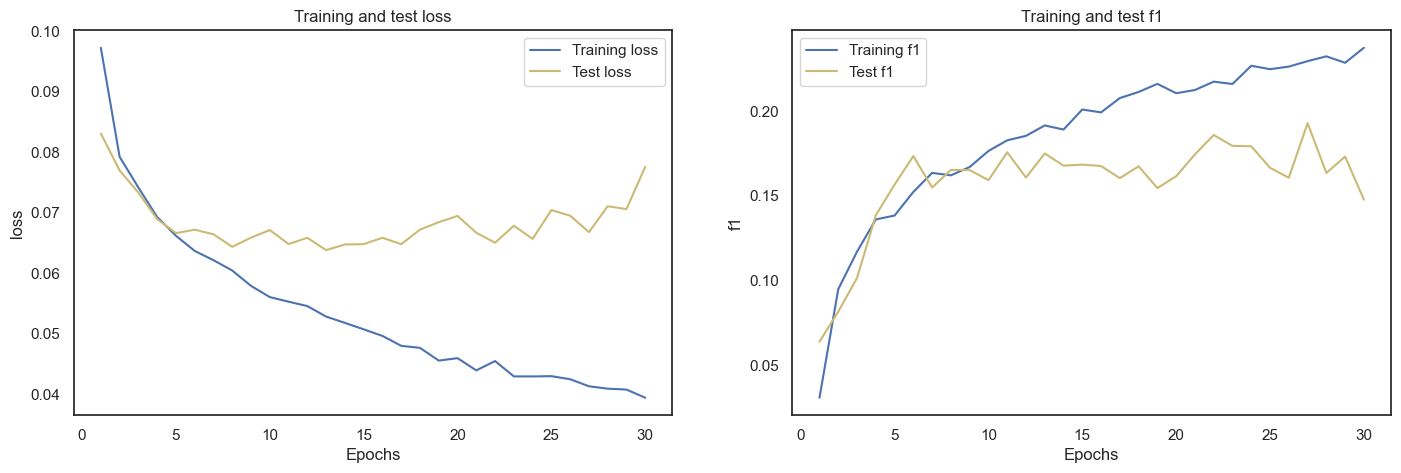

In [102]:
#Model1
# Define neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_HP.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

# Train model on the training set
class_weight = {0: 1, 1: 20} # adjust the class weight as needed
#history = model.fit(X_train_HP, y_train_HP, epochs=30, batch_size=32, class_weight=class_weight)
history = model.fit(X_train_HP, y_train_HP, validation_data=(X_test_HP, y_test_HP), epochs=30, batch_size=16, verbose=1)

# Evaluate model on the testing set
y_pred = model.predict(X_test_HP)
y_pred = np.round(y_pred)
f1 = f1_score(y_test_HP, y_pred)
print('F1 score:', f1)
plot_NNN(history, EPOCHS = 30)



Epoch 1/30
1565/1565 [==============================] - 22s 10ms/step - loss: 0.7232 - f1_m: 0.2216 - val_loss: 0.3097 - val_f1_m: 0.2738
Epoch 2/30
1565/1565 [==============================] - 12s 8ms/step - loss: 0.5723 - f1_m: 0.2675 - val_loss: 0.2308 - val_f1_m: 0.2820
Epoch 3/30
1565/1565 [==============================] - 10s 6ms/step - loss: 0.5205 - f1_m: 0.2794 - val_loss: 0.2707 - val_f1_m: 0.2858
Epoch 4/30
1565/1565 [==============================] - 10s 7ms/step - loss: 0.4828 - f1_m: 0.2944 - val_loss: 0.3396 - val_f1_m: 0.2861
Epoch 5/30
1565/1565 [==============================] - 7s 4ms/step - loss: 0.4493 - f1_m: 0.3060 - val_loss: 0.3047 - val_f1_m: 0.3049
Epoch 6/30
1565/1565 [==============================] - 9s 6ms/step - loss: 0.4185 - f1_m: 0.3219 - val_loss: 0.2627 - val_f1_m: 0.3086
Epoch 7/30
1565/1565 [==============================] - 9s 6ms/step - loss: 0.4061 - f1_m: 0.3235 - val_loss: 0.2779 - val_f1_m: 0.2986
Epoch 8/30
1565/1565 [=====================

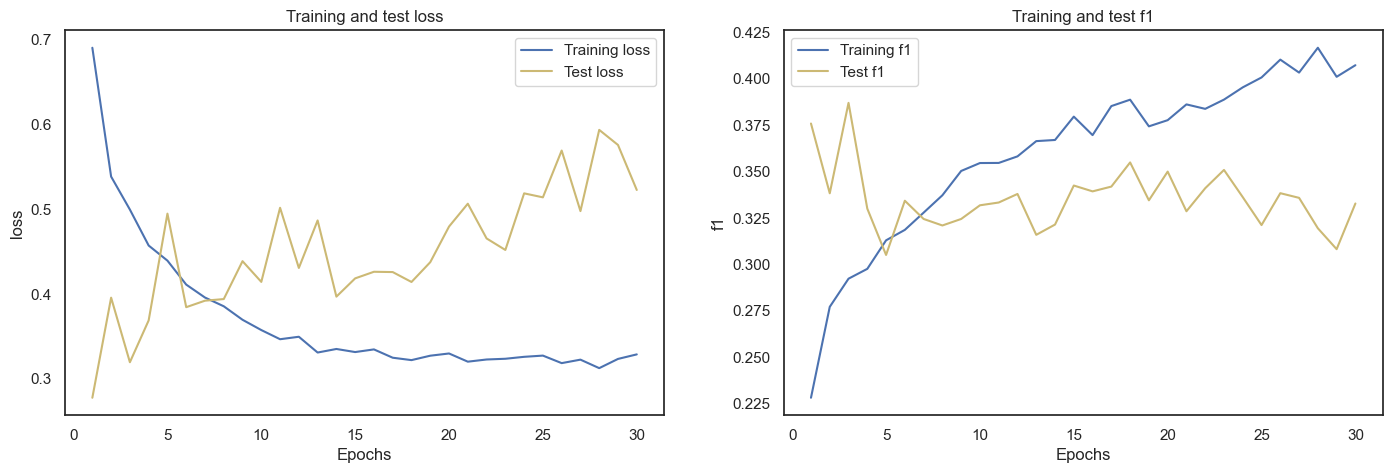

In [106]:
#Model2 - the one in the paper 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.optimizers import Nadam
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import numpy as np

# Define hyperparameters
n_layers = 3
n_neurons = 64
activation_func = 'relu'
output_activation = 'sigmoid'
l2_reg = 0.0005
optimizer = Nadam()
loss_func = 'binary_crossentropy'
class_weights = {0: 1, 1: 20}
batch_size = 32
epochs = 30

# Define K-fold cross validation
n_splits = 5
kf = KFold(n_splits=n_splits)

# Create a list to store F1 scores for each fold
f1_scores = []

# Loop over each fold
for train_index, test_index in kf.split(df_encoded):
    
    # Split the data into train and test sets for the current fold
    X_train, X_test = df_encoded.iloc[train_index], df_encoded.iloc[test_index]
    y_train, y_test = df['HasPitLap'].iloc[train_index], df['HasPitLap'].iloc[test_index]
    
    # Build neural network model
    model = Sequential()
    model.add(Dense(n_neurons, activation=activation_func, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(l2_reg)))
    for i in range(n_layers-1):
        model.add(Dense(n_neurons, activation=activation_func, kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dropout(0.3))
    model.add(Dense(1, activation=output_activation))
    
    # Compile the model
    model.compile(loss=loss_func, optimizer=optimizer, metrics=[f1_m])
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, class_weight=class_weights, verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
# Calculate the mean F1 score and standard deviation
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Print the mean F1 score and standard deviation
print('Mean F1 score:', mean_f1)
print('Standard deviation of F1 scores:', std_f1)


plot_NNN(history, EPOCHS = 30)


In [101]:
#NOTE To perform cross-validation with different hyperparameters, you can use GridSearchCV from scikit-learn

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a function to create the model
def create_model(batch_size=32, epochs=30):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train_HP.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
    return model

# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the hyperparameters to tune
batch_size = [16, 32, 64]
epochs = [10, 20, 30]

# Create the parameter grid
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1')

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_HP, y_train_HP, class_weight={0: 1, 1: 20})

# Print the results
print('Best score:', grid_result.best_score_)
print('Best params:', grid_result.best_params_)


/var/folders/zg/vx8l82y56zj94339h1sczjtw0000gn/T/ipykernel_1278/662599771.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=1)


Epoch 1/10
2190/2190 [==============================] - 11s 4ms/step - loss: 0.6732 - f1_m: 0.1556
Epoch 2/10
2190/2190 [==============================] - 12s 5ms/step - loss: 0.5329 - f1_m: 0.1923
Epoch 3/10
2190/2190 [==============================] - 7s 3ms/step - loss: 0.4911 - f1_m: 0.2031
Epoch 4/10
2190/2190 [==============================] - 11s 5ms/step - loss: 0.4471 - f1_m: 0.2139
Epoch 5/10
2190/2190 [==============================] - 8s 4ms/step - loss: 0.4255 - f1_m: 0.2243
Epoch 6/10
2190/2190 [==============================] - 7s 3ms/step - loss: 0.4140 - f1_m: 0.2238
Epoch 7/10
2190/2190 [==============================] - 6s 3ms/step - loss: 0.3900 - f1_m: 0.2230
Epoch 8/10
2190/2190 [==============================] - 6s 3ms/step - loss: 0.3599 - f1_m: 0.2421
Epoch 9/10
2190/2190 [==============================] - 6s 3ms/step - loss: 0.3463 - f1_m: 0.2367
Epoch 10/10
274/274 [==============================] - 0s 2ms/step
Epoch 1/10
2190/2190 [==========================